In [1]:
from datetime import datetime,timedelta
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 

In [1307]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(){return false}

<IPython.core.display.Javascript object>

In [3]:
df = pd.read_csv('0700_2011-12-07_2021-12-04.csv')
df['time_key'] = pd.to_datetime(df['time_key'])
df.set_index("time_key", inplace=True)

<AxesSubplot:title={'center':'Tencent 0700'}, xlabel='time_key'>

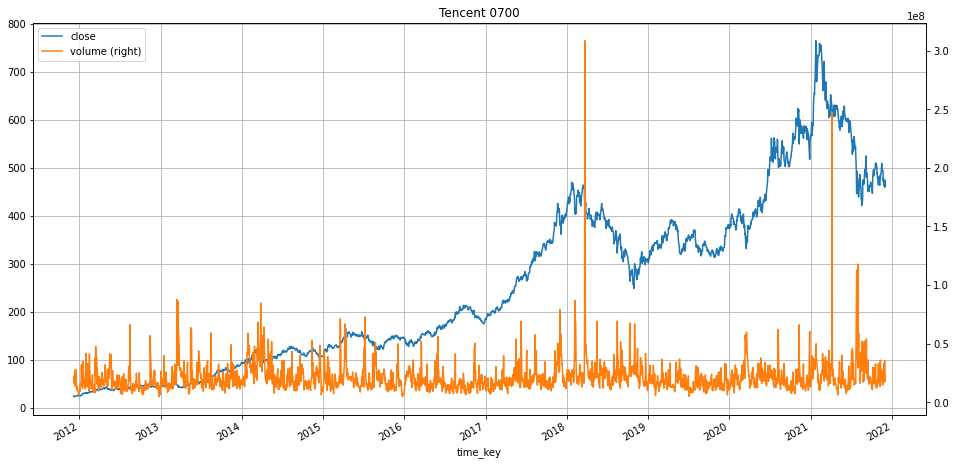

In [4]:
df[['close','volume']].plot(grid=True, title='Tencent 0700',figsize=(16,8),secondary_y=['volume'])  

In [1520]:
def max_drawdown(return_list):
    '''最大回撤率'''
    if return_list.size == 0:
        return 0, 0, 0
    i = np.argmax((np.maximum.accumulate(return_list) - return_list) / np.maximum.accumulate(return_list))  # 结束位置
    if i <= 0:
        return 0, 0, 0    
    j = np.argmax(return_list[:i])  # 开始位置
    return j, i, (return_list[j] - return_list[i]) / (return_list[j])

def sharpe_ratio(data):
    #公式 夏普率 = (回报率均值 - 无风险率) / 回报率的标准差,此处无风险利率为 0
    # pct_change()是pandas里面的自带的计算每日增长率的函数
    daily_return = data.pct_change()
    # 回报率均值 
    avg_return = daily_return.mean()
    # 回报率标准差
    std_return = daily_return.std()
    #计算夏普
    sharp = avg_return / std_return
    sharp_year = sharp * np.sqrt(252)
    return sharp, sharp_year

def calc_return(data):
    # Python计算量化策略评估指标 https://www.jianshu.com/p/363aa2dd3441
    # 净值 
    data_new=data/data.iloc[0]
    ### 区间累计收益率(绝对收益率)
    total_ret=data_new.iloc[-1]-1
    ###年化收益率,假设一年以365交易日计算
    annual_ret=pow(1+total_ret,365/(data_new.index[-1]-data_new.index[0]).days)-1
    return total_ret, annual_ret

In [1746]:
def show_data(data,title='return'):
    fig, ax1 = plt.subplots(figsize=(14,6))
    ax1.plot(data)
    txt = 'total ret: %.2f, annual ret: %.2f' % calc_return(data)
    ax1.text(0.02, 0.95, txt, transform=ax1.transAxes,fontsize=12)
    txt = 'sharp: %.2f, sharp year: %.2f' % sharpe_ratio(data)
    ax1.text(0.02, 0.9, txt, transform=ax1.transAxes,fontsize=12)
    
    begin, end, md = 0, 0, 0
    max_md, max_begin, max_end = 0, 0, 0

    begin, end, md = max_drawdown(data)    
    txt = 'max drawdown1(green):%.4f' % md
    ax1.text(0.02, 0.85, txt, transform=ax1.transAxes,fontsize=12)
    ax1.set_title(title)
    plt.fill_between([data.index[begin],data.index[end]], 0, data.max(), facecolor='green', alpha=0.3)
    
    parts = [data[data.index<data.index[begin]],data[data.index>data.index[end]]]
    max_md, max_begin, max_end = 0, 0, 0
    for part in parts:
        md = max_drawdown(part)
        if md[2] > max_md:
            max_md = md[2]
            max_begin = part.index[md[0]]
            max_end = part.index[md[1]]
    
    if max_begin != 0:
        txt = 'max drawdown2(yellow):%.4f' % max_md
        ax1.text(0.02, 0.8, txt, transform=ax1.transAxes, fontsize=12)
        plt.fill_between([max_begin,max_end], 0, data.max(), facecolor='yellow', alpha=0.3)

        dates = sorted([(data.index[begin],data.index[end]),(max_begin, max_end)])
        parts = [
            data[data.index < dates[0][0]],
            data[(data.index > dates[0][1]) & (data.index < dates[1][0])],
            data[data.index> dates[1][1]]
        ]
        max_md, max_begin, max_end = 0, 0, 0    
        for part in parts:
            md = max_drawdown(part)
            if md[2] > max_md:
                max_md = md[2]
                max_begin = part.index[md[0]]
                max_end = part.index[md[1]]

        if max_begin != 0:        
            txt = 'max drawdown3(blue):%.4f' % max_md
            ax1.text(0.02, 0.75, txt, transform=ax1.transAxes, fontsize=12)
            plt.fill_between([max_begin,max_end], 0, data.max(), facecolor='blue', alpha=0.3)
    
    plt.show()

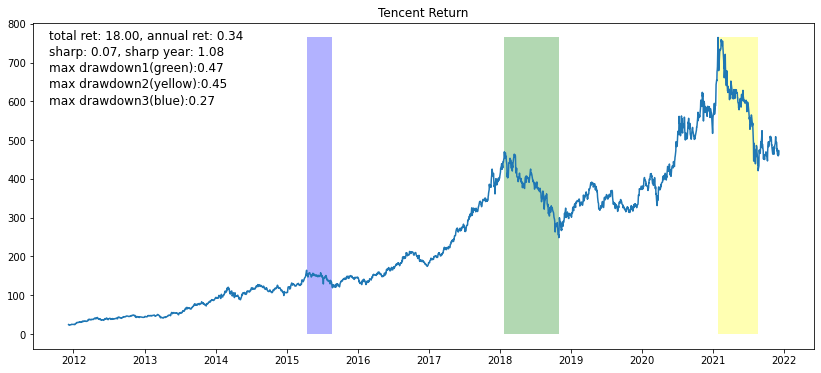

In [1632]:
show_data(df.close, 'Tencent Return')

In [1621]:
def real_vol(w):
    return (np.log(df['close']).diff()).rolling(w).std(ddof=0)*(252**0.5)

In [246]:
df['real_vol_22'] = real_vol(22)

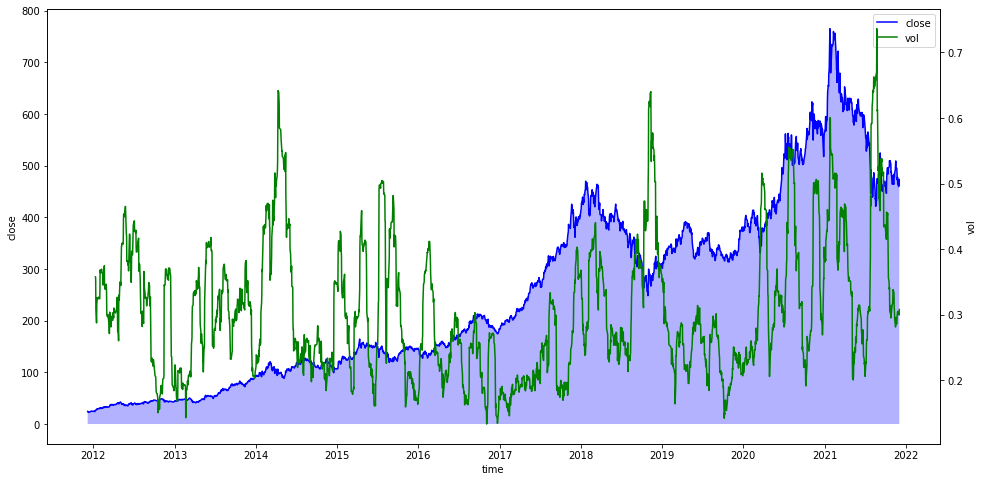

In [277]:
fig, ax1 = plt.subplots(figsize=(16,8))
ax2 = ax1.twinx()
line1 = ax1.plot(df['close'],'b',label='close')
line2 = ax2.plot(df['real_vol_22'],'g',label='vol') 

ax1.fill_between(df.index, 0, df['close'], facecolor='b', alpha=0.3)

lns = line1+line2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)


ax1.set_xlabel("time")
ax1.set_ylabel("close") 
ax2.set_ylabel("vol")

plt.show()

In [278]:
import utils

In [279]:
import random
index = random.randint(0, df.shape[0]-22)

In [280]:
row = df.iloc[-index]
row

Unnamed: 0                 60
code                 HK.00700
open                    410.0
close                   410.2
high                    412.2
low                     407.4
pe_ratio               38.304
turnover_rate         0.00164
volume               15666254
turnover         6478894874.0
change_rate          1.635282
last_close              403.6
real_vol_22          0.236906
Name: 2020-04-27 00:00:00, dtype: object

In [281]:
kargs = dict(
    asset_price=row.close,
    asset_volatility=row.real_vol_22,
    strike_price=row.close,
    time_to_expiration = 22/252,
    risk_free_rate = 0.015)
kargs

{'asset_price': 410.2,
 'asset_volatility': 0.23690621543103632,
 'strike_price': 410.2,
 'time_to_expiration': 0.0873015873015873,
 'risk_free_rate': 0.015}

In [282]:
option1 = utils.EuropeanCall(**kargs)
print('price={price:.2f},delta={delta:.2f},gamma={gamma:.2f},vega={vega:.2f}'.format(**option1.__dict__))

price=11.72,delta=0.52,gamma=0.02,vega=0.63


In [283]:
row2 = df.iloc[-index+22]
kargs = dict(
    asset_price=row2.close,
    asset_volatility=row2.real_vol_22,
    strike_price=row.close,
    time_to_expiration = 1/252,
    risk_free_rate = 0.015)
option2 = utils.EuropeanCall(**kargs)
print('price={price:.2f},delta={delta:.2f},gamma={gamma:.2f},vega={vega:.2f}'.format(**option2.__dict__))

price=2.85,delta=0.44,gamma=0.05,vega=0.11


In [284]:
option2.price - option1.price

-8.86145517567266

In [285]:
import imp; imp.reload(utils)

<module 'utils' from '/home/ubuntu/src/futu/utils.py'>

In [286]:
# 不同行权价
row = df.iloc[-index]
for i in range(-10, 10):
    option = utils.EuropeanCall(asset_price=row.close, asset_volatility=row.real_vol_22, strike_price=row.close+(i*2),
                                time_to_expiration=22/252, risk_free_rate = 0.015)
    print(option)

strike=390.20,dt=0.09,iv=0.24,price=24.29,delta=0.78,gamma=0.03,vega=0.94
strike=392.20,dt=0.09,iv=0.24,price=22.80,delta=0.76,gamma=0.03,vega=0.92
strike=394.20,dt=0.09,iv=0.24,price=21.36,delta=0.73,gamma=0.03,vega=0.89
strike=396.20,dt=0.09,iv=0.24,price=19.97,delta=0.71,gamma=0.02,vega=0.86
strike=398.20,dt=0.09,iv=0.24,price=18.63,delta=0.68,gamma=0.02,vega=0.83
strike=400.20,dt=0.09,iv=0.24,price=17.34,delta=0.66,gamma=0.02,vega=0.80
strike=402.20,dt=0.09,iv=0.24,price=16.10,delta=0.63,gamma=0.02,vega=0.77
strike=404.20,dt=0.09,iv=0.24,price=14.92,delta=0.60,gamma=0.02,vega=0.73
strike=406.20,dt=0.09,iv=0.24,price=13.80,delta=0.58,gamma=0.02,vega=0.70
strike=408.20,dt=0.09,iv=0.24,price=12.73,delta=0.55,gamma=0.02,vega=0.67
strike=410.20,dt=0.09,iv=0.24,price=11.72,delta=0.52,gamma=0.02,vega=0.63
strike=412.20,dt=0.09,iv=0.24,price=10.76,delta=0.49,gamma=0.02,vega=0.60
strike=414.20,dt=0.09,iv=0.24,price=9.85,delta=0.47,gamma=0.02,vega=0.56
strike=416.20,dt=0.09,iv=0.24,price=9.0

In [287]:
# 平值不同到期日期
row = df.iloc[-index]
for i in range(22):
    option = utils.EuropeanCall(asset_price=row.close, asset_volatility=row.real_vol_22, strike_price=row.close,
                                time_to_expiration=(22-i)/252, risk_free_rate = 0.015)
    print(option)

strike=410.20,dt=0.09,iv=0.24,price=11.72,delta=0.52,gamma=0.02,vega=0.63
strike=410.20,dt=0.08,iv=0.24,price=11.44,delta=0.52,gamma=0.02,vega=0.62
strike=410.20,dt=0.08,iv=0.24,price=11.16,delta=0.52,gamma=0.02,vega=0.60
strike=410.20,dt=0.08,iv=0.24,price=10.87,delta=0.52,gamma=0.02,vega=0.59
strike=410.20,dt=0.07,iv=0.24,price=10.58,delta=0.52,gamma=0.02,vega=0.57
strike=410.20,dt=0.07,iv=0.24,price=10.27,delta=0.52,gamma=0.02,vega=0.55
strike=410.20,dt=0.06,iv=0.24,price=9.96,delta=0.52,gamma=0.02,vega=0.54
strike=410.20,dt=0.06,iv=0.24,price=9.64,delta=0.52,gamma=0.02,vega=0.52
strike=410.20,dt=0.06,iv=0.24,price=9.30,delta=0.52,gamma=0.02,vega=0.50
strike=410.20,dt=0.05,iv=0.24,price=8.96,delta=0.52,gamma=0.02,vega=0.48
strike=410.20,dt=0.05,iv=0.24,price=8.60,delta=0.52,gamma=0.02,vega=0.46
strike=410.20,dt=0.04,iv=0.24,price=8.23,delta=0.52,gamma=0.03,vega=0.44
strike=410.20,dt=0.04,iv=0.24,price=7.84,delta=0.51,gamma=0.03,vega=0.42
strike=410.20,dt=0.04,iv=0.24,price=7.43,delt

In [1193]:
# 某期权随时间流逝
index = random.randint(0, df.shape[0]-22)
row = df.iloc[index]
options = []
for i in range(22):
    options.append(utils.EuropeanCall(asset_price=df.iloc[index+i].close, 
                                      asset_volatility=df.iloc[index+i].real_vol_22, 
                                      time_to_expiration=(22-i)/252,
                                      strike_price=row.close*1,                                       
                                      risk_free_rate = 0.015))
tempDf = pd.DataFrame(option.__dict__ for option in options)

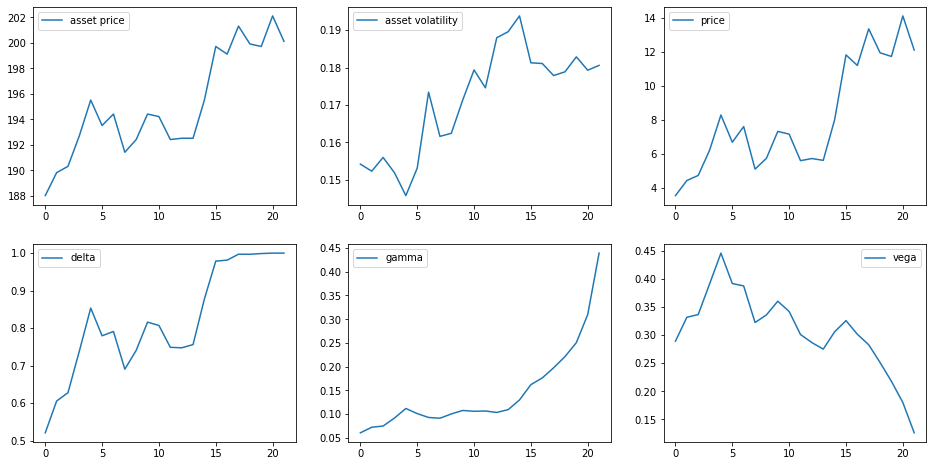

In [1194]:
plt.figure(figsize=(16,8))
plt.figure(1)

ax1 = plt.subplot(231)
plt.plot(tempDf['asset_price'], label='asset price')
ax1.legend()

ax2 = plt.subplot(232)
plt.plot(tempDf['asset_volatility'], label='asset volatility')
ax2.legend()

ax3 = plt.subplot(233)
plt.plot(tempDf['price'], label='price')
ax3.legend()

ax4 = plt.subplot(234)
plt.plot(tempDf['delta'], label='delta')
ax4.legend()

ax5 = plt.subplot(235)
plt.plot(tempDf['gamma'], label='gamma')
ax5.legend()

ax6 = plt.subplot(236)
plt.plot(tempDf['vega'], label='vega')
ax6.legend()

In [1983]:
def buy_call(data,index=-1, strike_factor=1, stop_loss=False):
    'strike_factor: 行权价虚实程度'
    expiration = 22 # 到期时间
    
    if index == -1:
        index = random.randint(0, data.shape[0]-expiration)
    open_row = data.iloc[index]
    open_option = utils.EuropeanCall(asset_price=open_row.close, 
                                     asset_volatility=open_row.real_vol_22, 
                                     time_to_expiration=expiration/252,
                                     strike_price=open_row.close*strike_factor, 
                                     risk_free_rate = 0.01)
    last_price = open_option.price
    for i in range(1,22+1):
        close_row = data.iloc[index+i]
        close_option = utils.EuropeanCall(asset_price=close_row.close, 
                                          asset_volatility=close_row.real_vol_22, 
                                          time_to_expiration=(22-i) or 0.0001/252, # 剩余时间不能为 0 ，可以是无限接近 0 
                                          strike_price=open_row.close*strike_factor, 
                                          risk_free_rate = 0.01)
        # 提前止损
        if stop_loss and close_option.price < last_price*0.8:
            print('bbb', i,data.index[index+i], round(close_option.price,2), round(open_option.price,2),
                  round(close_option.price - open_option.price,2),
                 round((close_option.price - open_option.price)/(open_option.price or 0.00001),2)
                 )            
            return (close_option.price - open_option.price)/(open_option.price or 0.00001)
        last_price = close_option.price
    return (close_option.price - open_option.price)/(open_option.price or 0.00001)

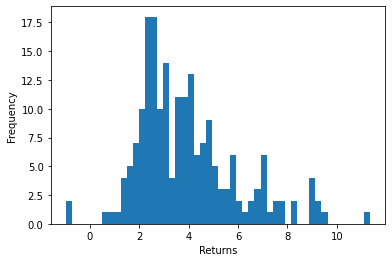

In [1904]:
# 概率分布
revenue = [buy_call(df,stop_loss=True) for i in range(200)]
plt.hist(revenue, bins=50, density=False)
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.show()

In [1905]:
s = pd.Series([buy_call(df,stop_loss=True) for i in range(100)])
# 胜率
pd.cut(s, [float('-inf'), 0, float('inf')], labels=['<=0', '>0']).value_counts()

>0     97
<=0     2
dtype: int64

In [1906]:
# 盈亏比
tempDf = pd.DataFrame(s, columns={'value'})
tempDf['category'] = tempDf['value'].apply(lambda x: '<=0' if x<=0 else '>0')
tempDf.groupby('category').sum('value')

,value
category,
<=0,-1.969707
>0,377.864594


<AxesSubplot:>

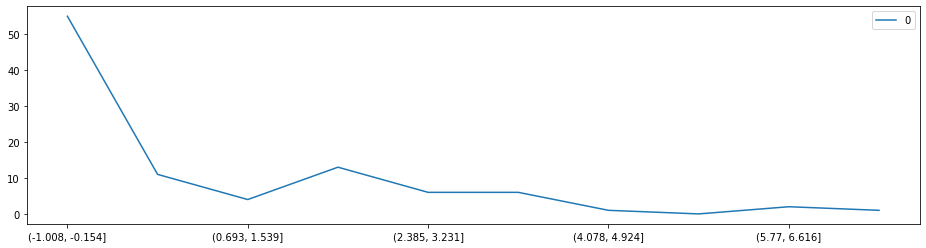

In [1908]:
# 盈利区间统计
pd.DataFrame(pd.cut([buy_call(df) for i in range(100)],10).value_counts()).plot(figsize=(16,4))

<AxesSubplot:xlabel='time_key'>

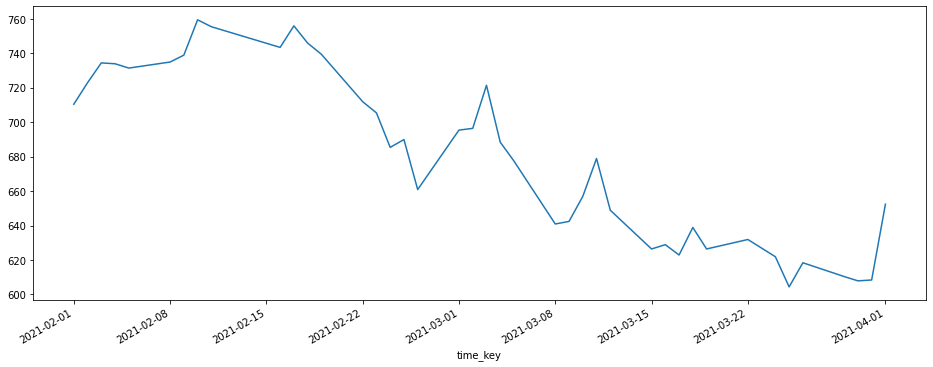

In [1992]:
# 某一段时间的走势
df.loc['2021-02-01':'2021-04-04']['close'].plot(figsize=(16,6))

In [1990]:
dft = df.loc['2020-01-01':'2022-01-01']
#dft = df

In [1991]:
import math
cash = 10000
position = 0.3 # 仓位比例
market_value = [[dft.index[0], cash]] # 市值
for i in range(22, len(dft.index) - 22, 22):
    rate_of_return = buy_call(dft, i, 1.05, True)
    if not math.isnan(rate_of_return):
        cash = cash + (cash*position)*rate_of_return
        print('aaa',i, round(rate_of_return,2), round(cash,2))
        market_value.append([dft.index[i], cash])

bbb 20 2020-03-04 00:00:00 54.16 4.69 49.47 10.56
aaa 22 10.56 41668.77
bbb 20 2020-04-03 00:00:00 92.79 5.65 87.14 15.42
aaa 44 15.42 234480.09
bbb 21 2020-05-12 00:00:00 61.58 14.43 47.15 3.27
aaa 66 3.27 464295.66
bbb 21 2020-06-11 00:00:00 53.54 6.27 47.27 7.54
aaa 88 7.54 1514661.96
bbb 22 2020-07-16 00:00:00 50.03 7.99 42.04 5.26
aaa 110 5.26 3905630.19
bbb 20 2020-08-13 00:00:00 147.01 16.46 130.56 7.93
aaa 132 7.93 13200671.62
bbb 17 2020-09-09 00:00:00 139.85 19.58 120.26 6.14
aaa 154 6.14 37518836.84
bbb 20 2020-10-19 00:00:00 83.89 9.84 74.06 7.53
aaa 176 7.53 122254673.88
bbb 20 2020-11-19 00:00:00 152.86 6.65 146.21 22.0
aaa 198 22.0 929045588.33
bbb 14 2020-12-11 00:00:00 224.11 22.9 201.21 8.79
aaa 220 8.79 3378437796.12
bbb 22 2021-01-26 00:00:00 119.03 7.8 111.23 14.26
aaa 242 14.26 17836378210.35
bbb 21 2021-02-26 00:00:00 70.62 36.2 34.41 0.95
aaa 264 0.95 22922592397.14
bbb 20 2021-03-29 00:00:00 120.32 17.39 102.93 5.92
aaa 286 5.92 63622180830.05
bbb 21 2021-05-04

<AxesSubplot:xlabel='date'>

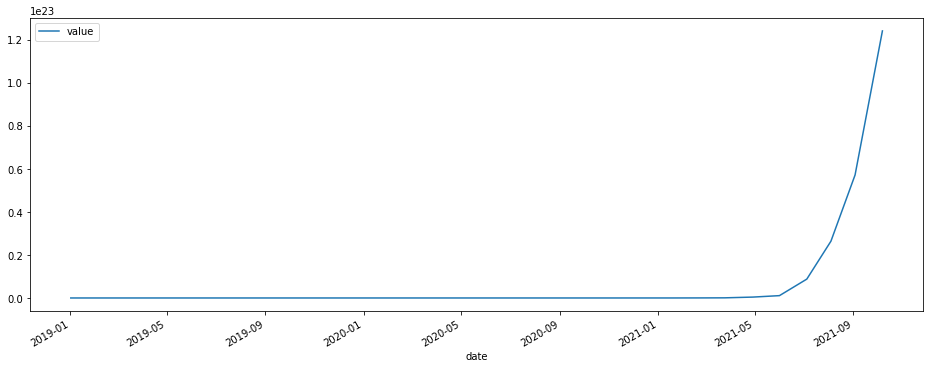

In [1967]:
t = pd.DataFrame(market_value, columns=['date','value'])
t = t.dropna().set_index('date')
t.plot(figsize=(16,6))

<AxesSubplot:>

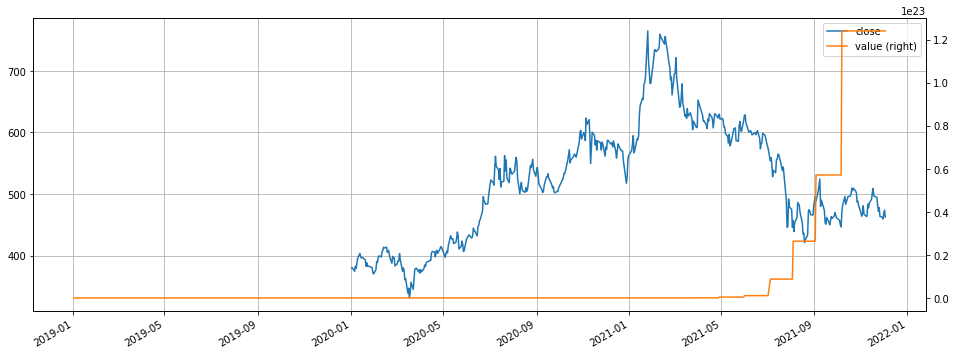

In [1985]:
t2 = pd.DataFrame([dft['close'],t['value']]).T
t2.fillna(method='ffill').plot(grid=True, figsize=(16,6),secondary_y=['value'])  

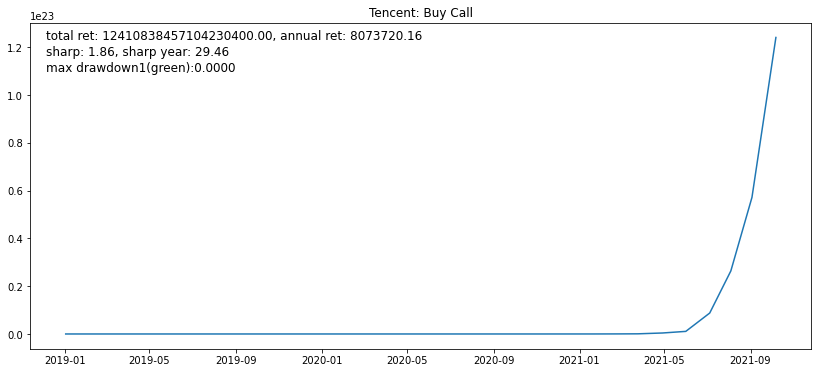

In [1969]:
show_data(t.value,'Tencent: Buy Call')

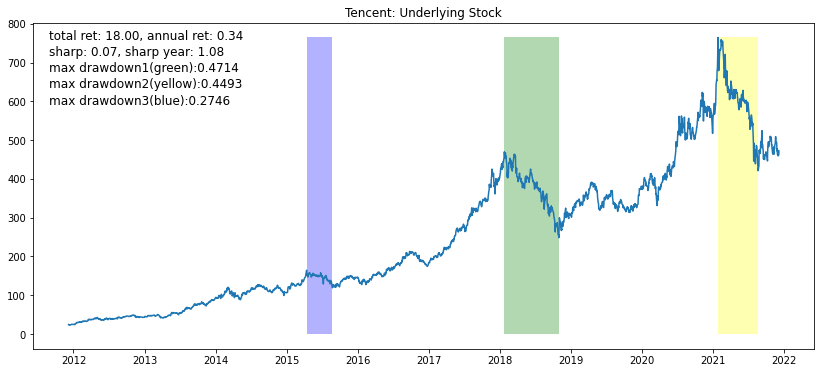

In [1937]:
show_data(df.close, 'Tencent: Underlying Stock')